In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *

## Load, Merge

### Load Solomon Islands' Census

In [2]:
data_folder = os.getcwd() + "/data/tourism"
solomon_folder = data_folder + "/solomon/intermediate/"
solomon_monthly = [solomon_folder + file for file in os.listdir(solomon_folder) if "month" in file]

In [3]:
solomon = (pd.read_csv(solomon_monthly[0])
           .drop(["Unnamed: 0", "Total"], axis=1))
solomon = solomon.melt(id_vars="Year")

In [4]:
solomon["month"] = [datetime.strptime(
    str(mon), '%B').month for mon in solomon.variable]

solomon = (solomon.sort_values(["Year", "month"])
           .reset_index().drop(["index", "variable"], axis=1)
           .rename({"value": "total"}, axis=1))
solomon["date"] = [str(year) + "-" + str(month) for year, month in zip(solomon.Year, solomon.month)]
solomon["date"] = pd.to_datetime(solomon["date"])
solomon.head(5)

,Year,total,month,date
0,2009,1602,1,2009-01-01
1,2009,1422,2,2009-02-01
2,2009,1249,3,2009-03-01
3,2009,1499,4,2009-04-01
4,2009,1393,5,2009-05-01


### Load `owid-covid-data`

In [5]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))

solomon_si = (covid_si[covid_si.location == "Solomon Islands"]
              .reset_index()
              .drop("index", axis=1))
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si.head(5)

,location,date,stringency_index
0,Solomon Islands,2020-10-12,43.52
1,Solomon Islands,2020-10-13,43.52
2,Solomon Islands,2020-10-14,43.52
3,Solomon Islands,2020-10-15,43.52
4,Solomon Islands,2020-10-16,43.52


In [6]:
oceania_si = (covid_si.groupby("date").mean()
              .reset_index()
              .rename({"stringency_index": "oceania_index"}, axis=1))
oceania_si["date"] = pd.to_datetime(oceania_si["date"])

solomon_si = (oceania_si.merge(solomon_si, how="left", on="date")
              .drop("location", axis=1))

In [7]:
solomon_si["year"], solomon_si["month"] = \
    solomon_si["date"].dt.year, solomon_si["date"].dt.month
solomon_si = solomon_si.groupby(["year", "month"]).mean().reset_index()
solomon_si["date"] = [str(year) + "-" + str(month)
                      for year, month in zip(solomon_si.year, solomon_si.month)]
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si = solomon_si.drop(["year", "month"], axis=1)

In [8]:
solomon = (solomon.merge(solomon_si, how="left", on="date")
           .rename({"stringency_index": "covid"}, axis=1)
           .fillna(0))
solomon.head(5)

,Year,total,month,date,oceania_index,covid
0,2009,1602,1,2009-01-01,0.0,0.0
1,2009,1422,2,2009-02-01,0.0,0.0
2,2009,1249,3,2009-03-01,0.0,0.0
3,2009,1499,4,2009-04-01,0.0,0.0
4,2009,1393,5,2009-05-01,0.0,0.0


## SARIMAX

In [9]:
get_adf_df(solomon, ["total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-2.602577,0.092466,3.0,140.0,-3.477945,-2.882416,-2.577902


In [10]:
sb = SARIMAXPipeline(data=solomon, y_var="total",
                     exog_var="covid", transform_method="scaledlogit",
                     training_ratio=0.975)

training size : 140, testing size : 4


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=450.696, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=450.611, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=435.427, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=432.436, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=448.710, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=432.231, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=432.048, Time=0.03 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=432.982, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=430.787, Time=0.11 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=432.760, Time=0.23 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=432.756, Time=0.27 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=433.625, Time=0.11 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=434.787, Time=0.36 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=448.900, Time=0.07 sec
 ARIMA(1,1,1)(1,0,1)[12] intercep

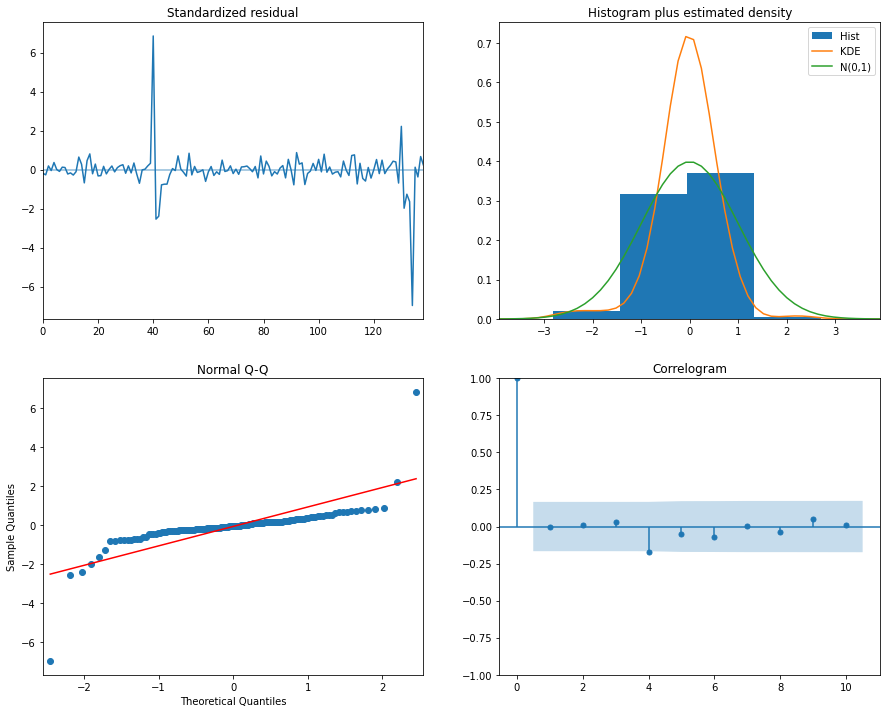

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [11]:
sb.transform()
sb.stepwise_search(d=1)

In [12]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0,2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
sb.manual_search(all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:513.29
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:510.96
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:512.82
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:502.69
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:490.35
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:491.6
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:510.81
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:512.8
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:514.43
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:499.3
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:491.79
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:493.52
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:512.8
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:514.58
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:513.98
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:497.93
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:492.9
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:491.02
Tried out SARIMAX(0, 0, 1)x(0, 0,

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 1)x(2, 0, 2, 12) - AIC:467.39
Tried out SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:456.82
Tried out SARIMAX(0, 0, 1)x(2, 1, 1, 12) - AIC:451.25
Tried out SARIMAX(0, 0, 1)x(2, 1, 2, 12) - AIC:450.04
Tried out SARIMAX(0, 0, 2)x(0, 0, 0, 12) - AIC:453.75
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:452.33
Tried out SARIMAX(0, 0, 2)x(0, 0, 2, 12) - AIC:453.81
Tried out SARIMAX(0, 0, 2)x(0, 1, 0, 12) - AIC:456.65
Tried out SARIMAX(0, 0, 2)x(0, 1, 1, 12) - AIC:430.9
Tried out SARIMAX(0, 0, 2)x(0, 1, 2, 12) - AIC:432.77
Tried out SARIMAX(0, 0, 2)x(1, 0, 0, 12) - AIC:451.8
Tried out SARIMAX(0, 0, 2)x(1, 0, 1, 12) - AIC:451.73
Tried out SARIMAX(0, 0, 2)x(1, 0, 2, 12) - AIC:453.59
Tried out SARIMAX(0, 0, 2)x(1, 1, 0, 12) - AIC:444.55
Tried out SARIMAX(0, 0, 2)x(1, 1, 1, 12) - AIC:432.79
Tried out SARIMAX(0, 0, 2)x(1, 1, 2, 12) - AIC:434.67
Tried out SARIMAX(0, 0, 2)x(2, 0, 0, 12) - AIC:453.37
Tried out SARIMAX(0, 0, 2)x(2, 0, 1, 12) - AIC:453.61
Tried out SARIMAX(0, 0, 2)x(2,

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 0)x(2, 0, 2, 12) - AIC:450.74
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:435.74
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:429.95
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:431.97
Tried out SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:430.55
Tried out SARIMAX(0, 1, 1)x(0, 0, 1, 12) - AIC:430.78
Tried out SARIMAX(0, 1, 1)x(0, 0, 2, 12) - AIC:431.97
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:444.15
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:410.28
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:412.25
Tried out SARIMAX(0, 1, 1)x(1, 0, 0, 12) - AIC:430.4
Tried out SARIMAX(0, 1, 1)x(1, 0, 1, 12) - AIC:429.02
Tried out SARIMAX(0, 1, 1)x(1, 0, 2, 12) - AIC:430.99
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:425.5
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:412.25
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:414.28
Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:431.33
Tried out SARIMAX(0, 1, 1)x(2, 0, 1, 12) - AIC:431.0
Tried out SARIMAX(0, 1, 1)x(2, 

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 0)x(2, 0, 2, 12) - AIC:435.7
Tried out SARIMAX(1, 0, 0)x(2, 1, 0, 12) - AIC:424.17
Tried out SARIMAX(1, 0, 0)x(2, 1, 1, 12) - AIC:417.99
Tried out SARIMAX(1, 0, 0)x(2, 1, 2, 12) - AIC:418.97
Tried out SARIMAX(1, 0, 1)x(0, 0, 0, 12) - AIC:428.8
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:429.18
Tried out SARIMAX(1, 0, 1)x(0, 0, 2, 12) - AIC:430.6
Tried out SARIMAX(1, 0, 1)x(0, 1, 0, 12) - AIC:443.91
Tried out SARIMAX(1, 0, 1)x(0, 1, 1, 12) - AIC:410.73
Tried out SARIMAX(1, 0, 1)x(0, 1, 2, 12) - AIC:412.71
Tried out SARIMAX(1, 0, 1)x(1, 0, 0, 12) - AIC:428.89
Tried out SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC:428.23
Tried out SARIMAX(1, 0, 1)x(1, 0, 2, 12) - AIC:430.22
Tried out SARIMAX(1, 0, 1)x(1, 1, 0, 12) - AIC:426.39
Tried out SARIMAX(1, 0, 1)x(1, 1, 1, 12) - AIC:412.71
Tried out SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC:414.18
Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:430.17
Tried out SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC:430.22


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 1)x(2, 0, 2, 12) - AIC:432.16
Tried out SARIMAX(1, 0, 1)x(2, 1, 0, 12) - AIC:420.69
Tried out SARIMAX(1, 0, 1)x(2, 1, 1, 12) - AIC:414.4
Tried out SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC:415.64
Tried out SARIMAX(1, 0, 2)x(0, 0, 0, 12) - AIC:429.86
Tried out SARIMAX(1, 0, 2)x(0, 0, 1, 12) - AIC:430.08
Tried out SARIMAX(1, 0, 2)x(0, 0, 2, 12) - AIC:431.4
Tried out SARIMAX(1, 0, 2)x(0, 1, 0, 12) - AIC:445.21
Tried out SARIMAX(1, 0, 2)x(0, 1, 1, 12) - AIC:410.27
Tried out SARIMAX(1, 0, 2)x(0, 1, 2, 12) - AIC:412.27
Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:429.74
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:428.34
Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:430.33
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:427.45
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:412.27
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:413.68
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:430.89
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:430.33


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:432.32
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:421.56
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:413.99
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:415.29
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:434.18
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:434.12
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:435.15
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:448.43
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:411.44
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:413.42
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:433.64
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:431.27
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:433.25
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:428.35
Tried out SARIMAX(1, 1, 0)x(1, 1, 1, 12) - AIC:413.42
Tried out SARIMAX(1, 1, 0)x(1, 1, 2, 12) - AIC:415.44
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:434.35
Tried out SARIMAX(1, 1, 0)x(2, 0, 1, 12) - AIC:433.25
Tried out SARIMAX(1, 1, 0)x(

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC:434.04
Tried out SARIMAX(1, 1, 2)x(2, 1, 0, 12) - AIC:422.05
Tried out SARIMAX(1, 1, 2)x(2, 1, 1, 12) - AIC:416.76


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC:418.06
Tried out SARIMAX(2, 0, 0)x(0, 0, 0, 12) - AIC:428.76
Tried out SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:428.94
Tried out SARIMAX(2, 0, 0)x(0, 0, 2, 12) - AIC:430.29
Tried out SARIMAX(2, 0, 0)x(0, 1, 0, 12) - AIC:443.49
Tried out SARIMAX(2, 0, 0)x(0, 1, 1, 12) - AIC:409.59
Tried out SARIMAX(2, 0, 0)x(0, 1, 2, 12) - AIC:411.58
Tried out SARIMAX(2, 0, 0)x(1, 0, 0, 12) - AIC:428.6
Tried out SARIMAX(2, 0, 0)x(1, 0, 1, 12) - AIC:427.53
Tried out SARIMAX(2, 0, 0)x(1, 0, 2, 12) - AIC:429.52
Tried out SARIMAX(2, 0, 0)x(1, 1, 0, 12) - AIC:425.88
Tried out SARIMAX(2, 0, 0)x(1, 1, 1, 12) - AIC:411.58
Tried out SARIMAX(2, 0, 0)x(1, 1, 2, 12) - AIC:413.06
Tried out SARIMAX(2, 0, 0)x(2, 0, 0, 12) - AIC:429.79
Tried out SARIMAX(2, 0, 0)x(2, 0, 1, 12) - AIC:429.52


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 0)x(2, 0, 2, 12) - AIC:431.5
Tried out SARIMAX(2, 0, 0)x(2, 1, 0, 12) - AIC:420.09
Tried out SARIMAX(2, 0, 0)x(2, 1, 1, 12) - AIC:413.29
Tried out SARIMAX(2, 0, 0)x(2, 1, 2, 12) - AIC:414.61
Tried out SARIMAX(2, 0, 1)x(0, 0, 0, 12) - AIC:430.46
Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:430.76
Tried out SARIMAX(2, 0, 1)x(0, 0, 2, 12) - AIC:432.13
Tried out SARIMAX(2, 0, 1)x(0, 1, 0, 12) - AIC:445.47
Tried out SARIMAX(2, 0, 1)x(0, 1, 1, 12) - AIC:411.59
Tried out SARIMAX(2, 0, 1)x(0, 1, 2, 12) - AIC:413.58
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:430.44
Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:429.48
Tried out SARIMAX(2, 0, 1)x(1, 0, 2, 12) - AIC:431.47
Tried out SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:427.85
Tried out SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC:413.58
Tried out SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:415.06
Tried out SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:431.66
Tried out SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC:431.47
Tried out SARIMAX(2, 0, 1)x(2

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:412.7
Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:430.14
Tried out SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:428.6
Tried out SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:430.59


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:428.43
Tried out SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:412.7


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:414.69
Tried out SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:431.38
Tried out SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC:430.6


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:432.58
Tried out SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:422.96


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:414.25


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:415.69
Tried out SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:431.92
Tried out SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:432.48
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:433.74
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:447.92
Tried out SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:412.25
Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:414.2
Tried out SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:432.18
Tried out SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:430.88
Tried out SARIMAX(2, 1, 0)x(1, 0, 2, 12) - AIC:432.83
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:428.32
Tried out SARIMAX(2, 1, 0)x(1, 1, 1, 12) - AIC:414.21
Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:416.25
Tried out SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:433.18
Tried out SARIMAX(2, 1, 0)x(2, 0, 1, 12) - AIC:432.84
Tried out SARIMAX(2, 1, 0)x(2, 0, 2, 12) - AIC:434.88
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:421.98
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 12) - AIC:415.93
Tried out SARIMAX(2, 1, 0)x(2

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:417.27
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:433.56
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:433.64
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:434.77
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:446.27
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:414.15
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:416.15
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:433.17
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:431.44
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:433.43
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:428.96
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:416.15
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:418.14
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:434.05
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:433.43
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:435.43
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:423.54
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:417.91


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:419.26


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13f658280>,
  513.292032160265,
  ((0, 0, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13fcb53d0>,
  510.9559333175951,
  ((0, 0, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13fcd53d0>,
  512.8199095984666,
  ((0, 0, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13fcf3490>,
  502.6932071506527,
  ((0, 0, 0), (0, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13fcd5220>,
  490.35327152894143,
  ((0, 0, 0), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13f8487c0>,
  491.603745970709,
  ((0, 0, 0), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13f848670>,
  510.81135398139804,
  ((0, 0, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13f8b3640>,
  512.8014758529974,

In [13]:
sb_msres = sb.manual_search_results
sb_msres.sort(key=lambda x: x[1])
sb_msres

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x3306dfe20>,
  409.58723545502176,
  ((2, 0, 0), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2abf29e20>,
  410.2748530619856,
  ((1, 0, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1598fde20>,
  410.27971047004866,
  ((0, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x333c140d0>,
  410.7058572322491,
  ((2, 0, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x287f25130>,
  410.7257856579957,
  ((1, 0, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13fb4e8e0>,
  411.4360399663295,
  ((1, 1, 0), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x3306dfe50>,
  411.57868898749774,
  ((2, 0, 0), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x3338a3df0>,
  411.57994145411

In [14]:
sb_sw = sb.stepwise_model
sb_models = []
sb_models.append(pm.ARIMA(
    sb_sw["order"], sb_sw["seasonal_order"],  exog=sb.exog[:sb.training_size]))

for res in sb_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=sb.exog[:sb.training_size])
    sb_models.append(model)
    
sb_comp = sb.compare_models(
    sb.transformed_y[:sb.training_size], sb.exog[:sb.training_size], sb_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/minif

[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/pmdarima/model_selection/_validation.py:94: ModelFitWarning: Estimator fit failed. The score on this train-test partition will be set to nan. Details: 
numpy.linalg.LinAlgError: LU decomposition error.

  warnings.warn("Estimator fit failed. The score on this train-test "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  wa

[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/mini

[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

In [15]:
sb_comp

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(2, 0, 0), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([137.79247183, 200.        ,  87.05264646, 124.81456124,
         122.036068  , 179.95175179,  77.3562278 , 104.5692209 ,
         148.64861712, 181.78213835,  95.40624208,  70.96602511,
          98.3112284 , 102.90577931,  71.97471938,  68.44430992,
          62.17290503,  55.44318228,  40.21444869, 115.52678653]),
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]),
  array([149.24206002, 143.33480242,  83.91604948,  79.30188461,
         105.06820236, 112.70215115, 106.44352252, 110.93358014,
         135.14053468, 121.94516199, 117.03039777, 106.82389385,

In [16]:
best_ss = sb_msres[2][0]
best_ss_mod = sb.get_prediction_df(
    best_ss, 4, sb.exog[-sb.test_size:])
lower = solomon["total"].min() - 1
upper = solomon["total"].max() + 1

for col_idx, col in enumerate(best_ss_mod.columns):
    for row_idx, _ in enumerate(best_ss_mod[col]):
        best_ss_mod.iloc[row_idx, col_idx] = sb.inverse_scaledlogit(
            best_ss_mod.iloc[row_idx, col_idx], upper, lower)
        
best_ss_mod = pd.concat([solomon[["date", "total"]], best_ss_mod], axis=1)
best_ss_mod.head(20)

/Users/czhang/Desktop/pacific-observatory/scripts/python/tsmodel.py:70: RuntimeWarning: overflow encountered in exp
  exp = np.exp(trans_series)
/Users/czhang/Desktop/pacific-observatory/scripts/python/tsmodel.py:71: RuntimeWarning: invalid value encountered in double_scalars
  inv_series = (((upper - lower) * exp) / (1 + exp)) + lower
/Users/czhang/Desktop/pacific-observatory/scripts/python/tsmodel.py:71: RuntimeWarning: overflow encountered in multiply
  inv_series = (((upper - lower) * exp) / (1 + exp)) + lower


,date,total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2009-01-01,1602,1562.000000,NaN,1.000000,NaN,NaN
1,2009-02-01,1422,1601.999984,NaN,1.000000,NaN,NaN
2,2009-03-01,1249,1422.000142,NaN,1.000000,NaN,NaN
3,2009-04-01,1499,1249.000135,NaN,1.000000,NaN,NaN
4,2009-05-01,1393,1498.999799,NaN,1.000000,NaN,NaN
5,2009-06-01,1724,1393.000084,NaN,1.000000,NaN,NaN
6,2009-07-01,1603,1723.999739,NaN,1.000000,NaN,NaN
7,2009-08-01,1520,1603.000096,NaN,1.000000,NaN,NaN
8,2009-09-01,1659,1520.000066,NaN,1.000000,NaN,NaN
9,2009-10-01,1709,1658.999890,NaN,1.000000,NaN,NaN


Text(0.5, 1.0, "Solomon Islands' Visitor Arrivals")

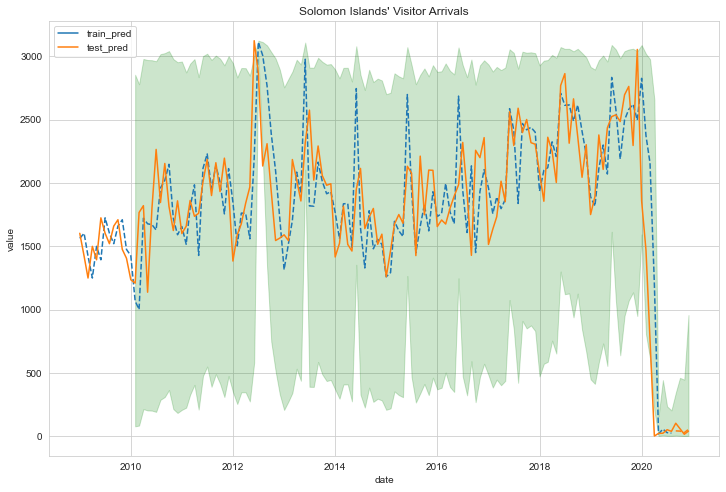

In [17]:
viz_df = best_ss_mod[["date", "train_pred", "test_pred"]].melt(id_vars=["date"])
viz_df["date"] = pd.to_datetime(viz_df["date"])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=best_ss_mod, x="date", y="total")
ax.fill_between(data=best_ss_mod, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2, color="green")
plt.title("Solomon Islands' Visitor Arrivals")

## VARMAX

In [18]:
merged_path = [solomon_folder + file for file in os.listdir(solomon_folder) if "merged" in file]
sb_merged = pd.read_csv(merged_path[0]).drop("Unnamed: 0", axis=1)
sb_merged["date"] = [str(y) + "-" + str(m) for y, m in zip(sb_merged.Year, sb_merged.Month)]
sb_merged["date"] = pd.to_datetime(sb_merged["date"])
sb_merged.head(5)

,Year,Month,Number_of_flights_intl,Number_of_flights_total,Seats_arrivals_intl,Seats_arrivals_total,Total,date
0,2019,1,69.0,69.0,10036.0,10036.0,1750.0,2019-01-01
1,2019,2,66.0,66.0,9471.0,9471.0,1891.0,2019-02-01
2,2019,3,69.0,71.0,9693.0,9965.0,2378.0,2019-03-01
3,2019,4,66.0,71.0,9532.0,10212.0,2106.0,2019-04-01
4,2019,5,69.0,73.0,9859.0,10403.0,2434.0,2019-05-01


## Ratio Approach

In [19]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_solomon_islands.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,solomon islands flights-AU,solomon islands hotel-AU,solomon islands travel-AU,solomon islands flights-NZ,solomon islands hotel-NZ,solomon islands travel-NZ,solomon islands flights-US,solomon islands hotel-US,solomon islands travel-US,...,solomon islands travel-JP,solomon islands flights-HK,solomon islands hotel-HK,solomon islands travel-HK,solomon islands flights-NC,solomon islands hotel-NC,solomon islands travel-NC,solomon islands flights,solomon islands hotel,solomon islands travel
0,2004-01-01,97,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,2.490457
1,2004-02-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.000000
2,2004-03-01,0,0,0,0,0,0,0,100,72,...,0,0,0,0,0,0,0,0.0,0.0,0.000000
3,2004-04-01,0,0,0,0,0,0,38,0,0,...,0,0,0,0,0,0,0,0.0,0.0,3.844978
4,2004-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.000000


In [20]:
sb_merged["ratio"] = sb_merged["Total"]/sb_merged["Seats_arrivals_intl"]
get_adf_df(sb_merged, ["ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ratio,-0.314284,0.923457,1.0,22.0,-3.769733,-3.005426,-2.642501


In [21]:
temp = sb_merged[["date", "ratio"]]
temp = temp.merge(oceania_si, how="left", on="date").fillna(0)
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
temp = (temp.merge(gt[["date", "solomon islands flights","solomon islands travel"]], 
                   how="left", on="date"))
temp.columns = [col.replace(" ", "_") for col in temp.columns]
temp.head(5)

,date,ratio,oceania_index,covid,quarter,solomon_islands_flights,solomon_islands_travel
0,2019-01-01,0.174372,0.0,False,1,0.112184,0.262692
1,2019-02-01,0.199662,0.0,False,1,0.094343,0.194975
2,2019-03-01,0.245332,0.0,False,1,0.197474,0.099021
3,2019-04-01,0.220940,0.0,False,2,0.275503,0.070665
4,2019-05-01,0.246881,0.0,False,2,0.266857,0.211019


In [26]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="ratio ~ covid * oceania_index + C(quarter) + solomon_islands_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.931
Model:                            WLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     30.71
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           4.02e-08
Time:                        17:52:11   Log-Likelihood:                 52.649
No. Observations:                  24   AIC:                            -89.30
Df Residuals:                      16   BIC:                            -79.87
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.1891      0.030      6.336      0.000       0.126       0.252
covid[T.True]                  -0.2349      0.062     -3.799      0.002      -0.366      -0.104
C(quarter)[T.2]                 0.0464      0.026      1.774      0.095      -0.009       0.102
C(quarter)[T.3]                 0.0737      0.023      3.204      0.006       0.025       0.122
C(quarter)[T.4]                 0.0565      0.024      2.391      0.029       0.006       0.107
oceania_index                  -0.0029      0.002     -1.600      0.129      -0.007       0.001
covid[T.True]:oceania_index     0.0032      0.002      1.464      0.163      -0.001       0.008
solomon_islands_travel          0.0657      0.126      0.523      0.608      -0.200       0.332
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   2.938
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.388
Skew:                           0.276   Prob(JB):                        0.824
Kurtosis:                       2.712   Cond. No.                         957.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)
ratio_stats.head(5)

,date,ratio,oceania_index,covid,quarter,solomon_islands_flights,solomon_islands_travel,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2019-01-01,0.174372,0.0,False,1,0.112184,0.262692,0.206331,0.018196,0.167757,0.244905,0.126363,0.286299
1,2019-02-01,0.199662,0.0,False,1,0.094343,0.194975,0.201882,0.016346,0.167230,0.236535,0.123730,0.280034
2,2019-03-01,0.245332,0.0,False,1,0.197474,0.099021,0.195579,0.020596,0.151917,0.239240,0.113036,0.278121
3,2019-04-01,0.220940,0.0,False,2,0.275503,0.070665,0.240127,0.018331,0.201268,0.278987,0.160021,0.320234
4,2019-05-01,0.246881,0.0,False,2,0.266857,0.211019,0.249348,0.021266,0.204266,0.294430,0.166045,0.332651


In [84]:
colnames_mean = [col for col in ratio_stats.columns if col.startswith('mean')]
for col in colnames_mean:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "predicted")
        sb_merged[colname] = sb_merged["Seats_arrivals_intl"] * ratio_stats[col]

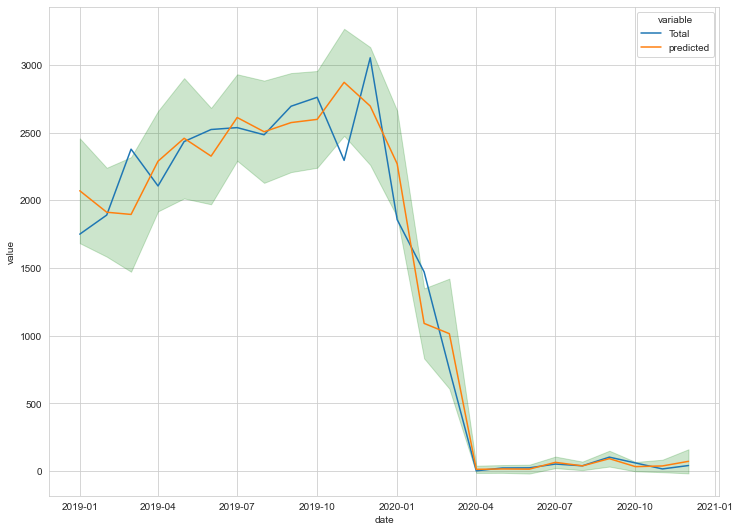

In [88]:
viz_df = sb_merged[["date", "Total", "predicted"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=sb_merged, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
plt.show()

### Future Forecasting

In [92]:
solomon_si_fu = (solomon_si[solomon_si.date >="2021-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (solomon_si_fu.merge(
    gt[["date", "solomon islands flights", "solomon islands travel"]],
    how="left", on="date"))
temp_fu["covid"] = temp_fu.date >= "2020-03-12"
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu

,oceania_index,stringency_index,date,solomon_islands_flights,solomon_islands_travel,covid,quarter
0,41.731237,33.330000,2021-01-01,0.077367,0.116740,True,1
1,41.899583,33.330000,2021-02-01,0.126842,0.000000,True,1
2,41.022742,33.330000,2021-03-01,0.174213,0.067311,True,1
3,41.708619,32.219333,2021-04-01,0.228631,0.177929,True,2
4,40.110092,25.000000,2021-05-01,0.074375,0.083363,True,2
5,42.542000,25.000000,2021-06-01,0.188133,0.184996,True,2
6,43.060726,30.376774,2021-07-01,0.141392,0.219227,True,3
7,50.727782,38.890000,2021-08-01,0.158122,0.060973,True,3
8,53.614417,32.594333,2021-09-01,0.118315,0.111711,True,3
9,52.584032,27.780000,2021-10-01,0.120201,0.095411,True,4


In [62]:
future = res.get_prediction(temp).summary_frame()
future["date"] = temp_fu["date"]

In [77]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

sb_avi = (aviation[(aviation.ISO == "SB") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
sb_avi["Date"] = pd.to_datetime(sb_avi["Date"])
sb_avi["Month"], sb_avi["Year"] = sb_avi["Date"].dt.month, sb_avi["Date"].dt.year
sb_avi = sb_avi.groupby(["Year", "Month"]).sum().reset_index()
sb_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(sb_avi.Year, sb_avi.Month)]
sb_avi["date"] = pd.to_datetime(sb_avi["date"])
sb_avi_future = sb_avi[sb_avi.date >= "2021-01-01"].reset_index().drop("index", axis=1)
sb_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2021,1,1408,1408,2021-01-01
1,2021,2,1640,1640,2021-02-01
2,2021,3,1632,1632,2021-03-01
3,2021,4,2164,2164,2021-04-01
4,2021,5,1292,1444,2021-05-01


In [90]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "predicted")
        future[colname] = sb_avi_future["Seats_arrivals_intl"] * future[col]
future

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,predicted,predicted_ci_lower,predicted_ci_upper
0,0.206331,0.018196,0.167757,0.244905,0.126363,0.286299,2021-01-01,290.513977,236.201342,344.826611
1,0.201882,0.016346,0.167230,0.236535,0.123730,0.280034,2021-02-01,331.086953,274.257051,387.916854
2,0.195579,0.020596,0.151917,0.239240,0.113036,0.278121,2021-03-01,319.184169,247.928880,390.439459
3,0.240127,0.018331,0.201268,0.278987,0.160021,0.320234,2021-04-01,519.635820,435.543253,603.728386
4,0.249348,0.021266,0.204266,0.294430,0.166045,0.332651,2021-05-01,322.157730,263.911316,380.404143
5,0.244138,0.017614,0.206797,0.281478,0.164757,0.323518,2021-06-01,299.801052,253.946950,345.655154
6,0.274310,0.015818,0.240776,0.307843,0.196647,0.351972,2021-07-01,498.146379,437.249522,559.043237
7,0.268421,0.019078,0.227977,0.308865,0.187534,0.349307,2021-08-01,396.994047,337.177379,456.810714
8,0.279259,0.018722,0.239569,0.318948,0.198747,0.359771,2021-09-01,471.388896,404.392999,538.384793
9,0.257878,0.016735,0.222401,0.293356,0.179357,0.336400,2021-10-01,598.277764,515.970061,680.585467


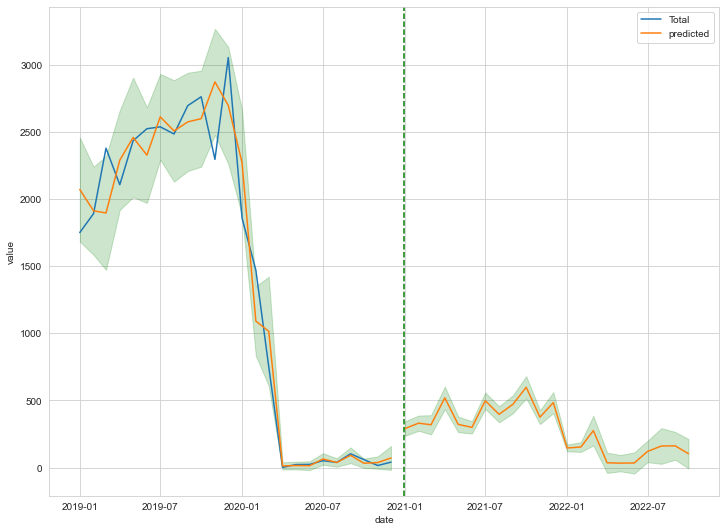

In [91]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=sb_merged, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
sns.lineplot(data=future, x="date", y="predicted")
ax.fill_between(data=future, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
plt.axvline(datetime(2020, 12, 31), linestyle="--", color="green")
plt.show()